# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
from collections import Counter

In [ ]:
### google.colab 연결 ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 셋 읽어오기

In [ ]:
### google.colab - data ###
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LGaimers/data/pre_train.csv') # 학습용 데이터
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LGaimers/data/pre_test.csv") # 테스트 데이터(제출파일의 데이터)

In [ ]:
### jupyter notebook - data ###
# df_train = pd.read_csv("train.csv") # 학습용 데이터
# df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [ ]:
df_train.head().T # 학습용 데이터 살펴보기

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
bant_submit,1.0,1.0,1.0,1.0,1.0
customer_country,Philippines,Philippines,India,India,India
business_unit,AS,AS,AS,AS,AS
com_reg_ver_win_rate,0.066667,0.066667,0.088889,0.088889,0.088889
customer_idx,32160,23122,1755,4919,17126
customer_type,End Customer,End Customer,End Customer,End Customer,Specifier/ Influencer
enterprise,Enterprise,Enterprise,Enterprise,Enterprise,Enterprise
historical_existing_cnt,4.0,12.0,144.0,4.0,4.0
id_strategic_ver,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
id,19844,9738,8491,19895,10465
bant_submit,0.0,0.25,1.0,0.5,1.0
customer_country,Brazil,United States,U.A.E,United States,Brazil
business_unit,ID,IT,ID,ID,ID
com_reg_ver_win_rate,0.073248,0.0,0.0,0.118644,0.074949
customer_idx,47466,5405,13597,17204,2329
customer_type,End Customer,End Customer,Specifier/ Influencer,NaN,End Customer
enterprise,Enterprise,SMB,SMB,Enterprise,Enterprise
historical_existing_cnt,53.0,0.0,0.0,0.0,2.0


## 피쳐 요약표

In [ ]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    summary['세 번째 값'] = df.loc[2].values

    return summary

In [ ]:
resumetable(df_train) #.sort_values(by='결측값 개수') #정렬기준

데이터 세트 형상: (59299, 32)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,Unnamed: 0,int64,0,59299,0,1,2
1,bant_submit,float64,0,5,1.0,1.0,1.0
2,customer_country,object,3482,170,Philippines,Philippines,India
3,business_unit,object,0,5,AS,AS,AS
4,com_reg_ver_win_rate,float64,0,81,0.066667,0.066667,0.088889
5,customer_idx,int64,0,35112,32160,23122,1755
6,customer_type,object,43961,6,End Customer,End Customer,End Customer
7,enterprise,object,0,2,Enterprise,Enterprise,Enterprise
8,historical_existing_cnt,float64,0,136,4.0,12.0,144.0
9,id_strategic_ver,float64,0,2,0.0,0.0,0.0


In [ ]:
resumetable(df_test)

데이터 세트 형상: (5271, 33)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,Unnamed: 0,int64,0,5271,0,1,2
1,id,int64,0,5271,19844,9738,8491
2,bant_submit,float64,0,5,0.0,0.25,1.0
3,customer_country,object,235,86,Brazil,United States,U.A.E
4,business_unit,object,0,3,ID,IT,ID
5,com_reg_ver_win_rate,float64,0,78,0.073248,0.0,0.0
6,customer_idx,int64,0,4069,47466,5405,13597
7,customer_type,object,1457,5,End Customer,End Customer,Specifier/ Influencer
8,enterprise,object,0,2,Enterprise,SMB,SMB
9,historical_existing_cnt,float64,0,74,53.0,0.0,0.0


In [ ]:
### 결측치가 있는 컬럼 확인###
def missing_values_table(df):
    # 결측치가 있는 컬럼 선택
    missing_cols = df.columns[df.isnull().any()].tolist()

    # 결측치가 있는 컬럼의 이름과 결측치 수를 저장할 리스트 생성
    col_names = []
    missing_counts = []
    unique_counts = []
    # 각 결측치가 있는 컬럼의 이름과 결측치 수 저장
    for col in missing_cols:
        col_names.append(col)
        missing_counts.append(df[col].isnull().sum())
        unique_counts.append(df[col].nunique())

    # 결과를 데이터프레임으로 변환
    missing_df = pd.DataFrame({'컬럼명': col_names, '결측치': missing_counts, '고유값': unique_counts})

    return missing_df

print("train데이터 결측치 :")
print(missing_values_table(df_train))
print("test데이터 결측치 :")
print(missing_values_table(df_test)) # train 데이터와 달리 customer_position.1의 결측치가 0

train데이터 결측치 :
                   컬럼명    결측치    고유값
0     customer_country   3482    170
1        customer_type  43961      6
2  product_subcategory  50064    330
3    product_modelname  50070    665
4   customer_country.1    982  15399
5     business_subarea  53773     86
6      customer_region   3482      6
test데이터 결측치 :
                   컬럼명   결측치  고유값
0     customer_country   235   86
1        customer_type  1457    5
2  product_subcategory  4478  150
3    product_modelname  4709  190
4     business_subarea  3455   80
5      customer_region   235    5


# 피처 요약표 파악

1. 이진형 피쳐
2. 순서형 미쳐
3. 명목형 피쳐
4. 그 외 수치형 피쳐
로 파악하여 개별적으로 인코딩을 해보자

## 데이터 시각화를 통한 타깃값 분포

### 타깃값 분포
먼저, 타깃값 분포를 통해 데이터가 얼마나 불균형 한지 확인 -> 부족한 데이터에 집중해서 데이터 불균형을 해결하는 방식으로 모델링

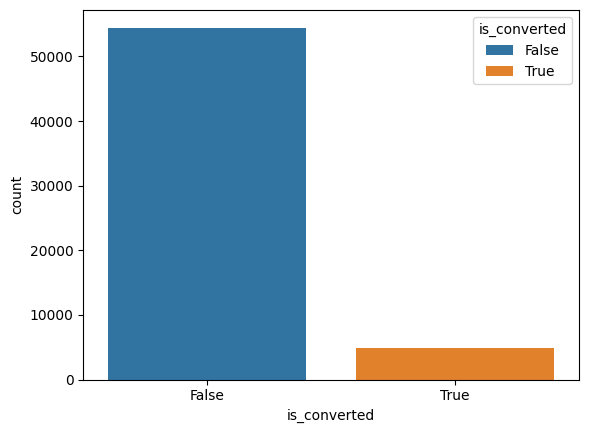

학습 데이터 레이블 값 비율
[54449, 4850]
False    91.82111
True      8.17889
Name: is_converted, dtype: float64
테스트 데이터 레이블 값 비율
[4083, 1188]
False    77.461582
True     22.538418
Name: is_converted, dtype: float64


In [ ]:
# 타깃값 분포
## 타깃값 분포를 통해 데이터가 얼마나 불균형 한지 확인 -> 부족한 데이터에 집중해 모델링

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# order_grade = ['True','False']
sns.countplot(x= 'is_converted', data = df_train, hue = 'is_converted')
plt.show()

print('학습 데이터 레이블 값 비율')
print(df_train['is_converted'].value_counts().to_list())
print(df_train['is_converted'].value_counts()/df_train['is_converted'].shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(df_test['is_converted'].value_counts().to_list())
print(df_test['is_converted'].value_counts()/df_test['is_converted'].shape[0] * 100)

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

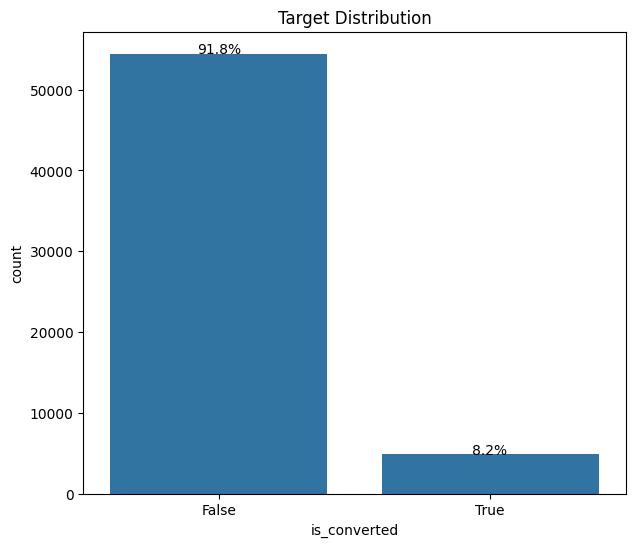

In [ ]:
def write_percent(ax, total_size):
    '''도형 객체를 순회하며 막대 상단에 타깃값 비율 표시'''
    for patch in ax.patches:
        height = patch.get_height()     # 도형 높이(데이터 개수)
        width = patch.get_width()       # 도형 너비
        left_coord = patch.get_x()      # 도형 왼쪽 테두리의 x축 위치
        percent = height/total_size*100 # 타깃값 비율

        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0,    # x축 위치
                y=height + total_size*0.001, # y축 위치
                s=f'{percent:1.1f}%',        # 입력 텍스트
                ha='center')                 # 가운데 정렬

plt.figure(figsize=(7, 6))

ax = sns.countplot(x='is_converted', data=df_train)
write_percent(ax, len(df_train)) # 비율 표시
ax.set_title('Target Distribution');

## 1. 이진형 피쳐

고유값이 2개인 피쳐


- 'id_strategic_ver','it_strategic_ver','idit_strategic_ver'
는 0과 1로 이미 인코딩되어 있음
- 'ver_pro', 'ver_cus'는 가중치 이므로 그대로 0/1로 유지
- 'enterprise'는 순서대로 'SMB'는 0, '  Enterprise는 1로 인코딩
- label 의 is_converted 만T는 1, False는 0 으로 인코딩

In [ ]:
bin_features = ['id_strategic_ver',
                 'it_strategic_ver',
                 'idit_strategic_ver',
                  'ver_pro', 'ver_cus',
                  'enterprise' ]
binary_feature_data = df_train[bin_feature]

In [ ]:
df_train['enterprise'].value_counts()

Enterprise    37783
SMB           21516
Name: enterprise, dtype: int64

In [ ]:
resumetable(binary_feature_data)

데이터 세트 형상: (59299, 6)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,id_strategic_ver,float64,0,2,0.0,0.0,0.0
1,it_strategic_ver,float64,0,2,0.0,0.0,0.0
2,idit_strategic_ver,float64,0,2,0.0,0.0,0.0
3,ver_pro,int64,0,2,0,0,0
4,ver_cus,int64,0,2,1,1,1
5,enterprise,object,0,2,Enterprise,Enterprise,Enterprise


### 이진 피처 분포

- 타겟값별 이진 피쳐분포 확인

bin_features = ['id_strategic_ver',
                 'it_strategic_ver',
                 'idit_strategic_ver',
                  'ver_pro', 'ver_cus',
                  'enterprise' ]

컬럼별 T/F 분포 비율이 is_converted와 동일하게 9:1로 유지되므로 이진 피쳐들은 특정 타겟값에 치우지지 않음 => 따라서 전부 원-핫 인코딩

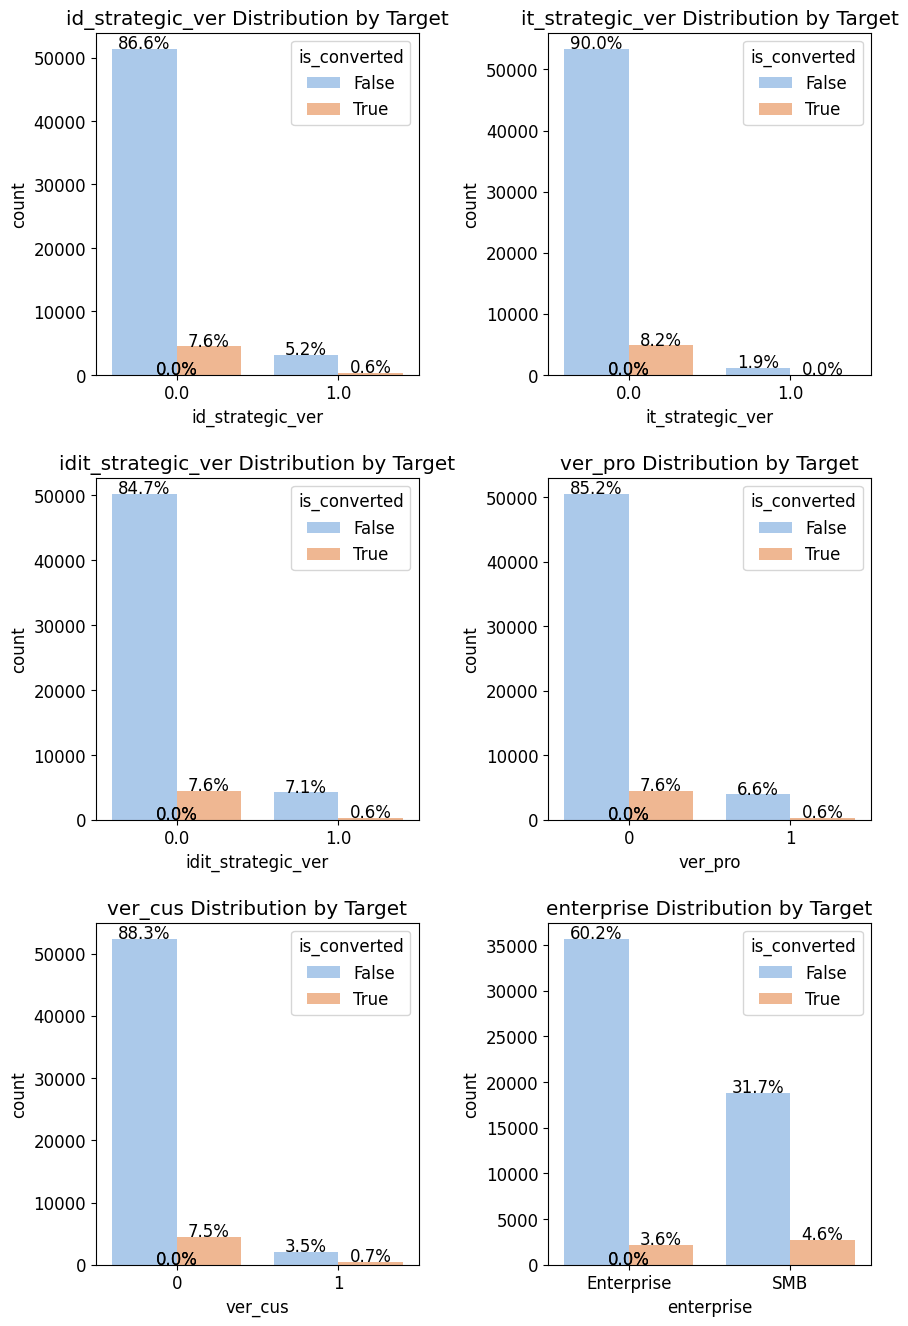

In [ ]:
import matplotlib.gridspec as gridspec # 여러 그래프를 격자 형태로 배치

# 3행 2열 틀(Figure) 준비
mpl.rc('font', size=12)
grid = gridspec.GridSpec(3, 2) # 그래프(서브플롯)를 3행 2열로 배치
plt.figure(figsize=(10, 16))   # 전체 Figure 크기 설정
plt.subplots_adjust(wspace=0.4, hspace=0.3) # 서브플롯 간 좌우/상하 여백 설정

# 서브플롯 그리기
bin_feature = ['id_strategic_ver',
                 'it_strategic_ver',
                 'idit_strategic_ver',
                  'ver_pro', 'ver_cus',
                  'enterprise' ] # 피처 목록

for idx, feature in enumerate(bin_feature):
    ax = plt.subplot(grid[idx])

    # ax축에 타깃값 분포 카운트플롯 그리기
    sns.countplot(x=feature,
                  data=df_train,
                  hue='is_converted',
                  palette='pastel', # 그래프 색상 설정
                  ax=ax)

    ax.set_title(f'{feature} Distribution by Target') # 그래프 제목 설정
    write_percent(ax, len(df_train))                     # 비율 표시

- 이진 피처 고윳값별 타깃값 1 비율 확인

✅결론

1. ver_pro 제거 - 고윳값별 타깃값 비율 차이가 없어, 타깃값 예측력이 없음
2. irit 3개 제거 보류-> 신뢰구간이 넓어 통계쩍 유효성 떨어짐. 그러나 신뢰구간의 길이가 애매해 보류

In [ ]:
### 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기 ###

import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, target_col, num_rows, num_cols, size=(12, 18)):
    mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows, num_cols)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y=target_col, data=df, palette='Set2', ax=ax)
        ax.set_xlabel(feature)


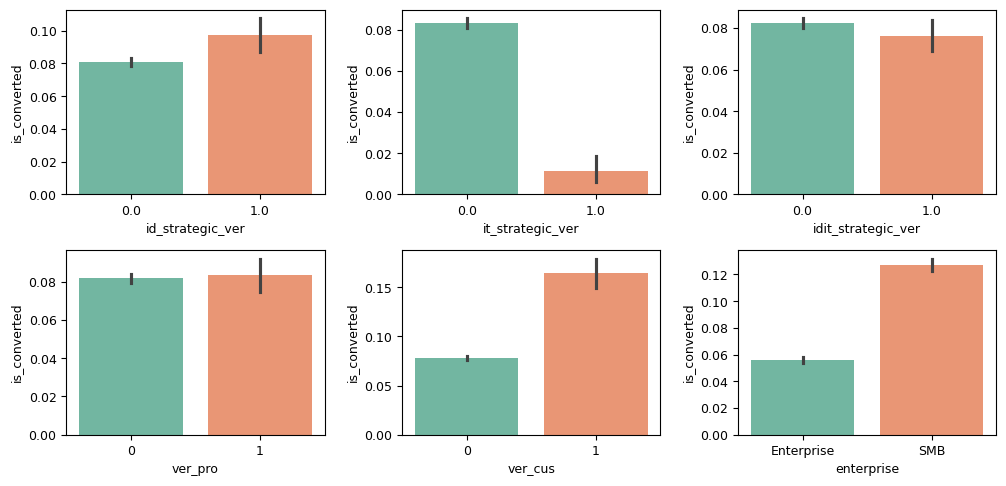

In [ ]:
plot_target_ratio_by_features(df_train, bin_features,'is_converted',6, 3) # 6행 3열 배치

##2. 순서형 피쳐

- expected_timeline 은 고유값의 순서에 맞게 인코딩
- bant_submit 도 점점 커지는 순서로 인코딩

In [ ]:
# 범주형 / 순서형
ord_features = ['expected_timeline',
                'bant_submit'  ]
ord_feature_data = df_train[ord_features]
resumetable(ord_feature_data)

데이터 세트 형상: (59299, 2)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,expected_timeline,object,0,6,Less than 3 months,Less than 3 months,Less than 3 months
1,bant_submit,float64,0,5,1.0,1.0,1.0


### 순서형 피쳐 분포

순서 피쳐 분포 및 피처별 타깃값 1의 비율

'expected_timeline', 'bant_submit' 는 순서에 따라 타깃값 1과의 우상향/우하향의 선형관계 가질 것이라고 예상했으나, 확인 결과 연관성이 없었음

=>따라서, 명목형 변수와 동일하게 순서상관없이 원핫 인코딩

In [ ]:
# 교차분석표 생성 함수
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['is_converted'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

In [ ]:
# 시각화 그래프 생성 함수
def plot_pointplot(ax, feature, crosstab):
    ax2 = ax.twinx() # x축은 공유하고 y축은 공유하지 않는 새로운 축 생성
    # 새로운 축에 포인트플롯 그리기
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab,
                        order=crosstab[feature].values, # 포인트플롯 순서
                        color='black',                  # 포인트플롯 색상
                        legend=False)                   # 범례 미표시
    ax2.set_ylim(crosstab[1].min()-5, crosstab[1].max()*1.1) # y축 범위 설정
    ax2.set_ylabel('Target 1 Ratio(%)')

def plot_cat_dist_with_true_ratio(df, features, num_rows, num_cols,
                                  size=(15, 20)):
    plt.figure(figsize=size)  # 전체 Figure 크기 설정
    grid = gridspec.GridSpec(num_rows, num_cols) # 서브플롯 배치
    plt.subplots_adjust(wspace=0.45, hspace=0.5) # 서브플롯 좌우/상하 여백 설정

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature) # 교차분석표 생성

        # ax축에 타깃값 분포 카운트플롯 그리기
        sns.countplot(x=feature, data=df,
                      order=crosstab[feature].values,
                      color='skyblue',
                      ax=ax)

        write_percent(ax, len(df)) # 비율 표시

        plot_pointplot(ax, feature, crosstab) # 포인트플롯 그리기

        ax.set_title(f'{feature} Distribution') # 그래프 제목 설정

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # X 축 라벨 기울이기

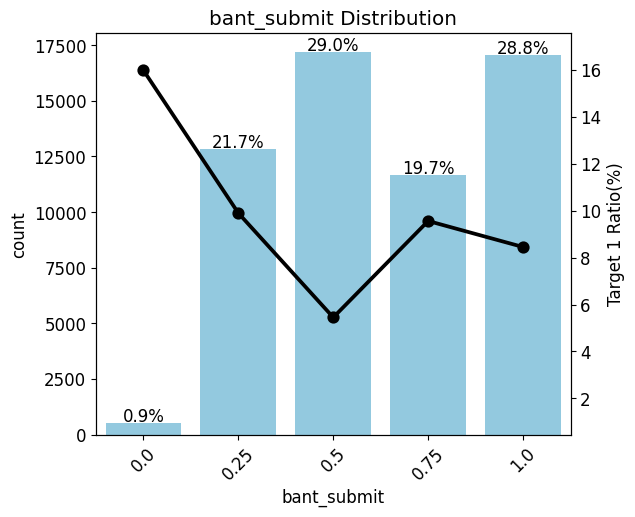

In [ ]:
ord_2 = [ # 'expected_timeline',
                'bant_submit'  ] # 순서형 피처
plot_cat_dist_with_true_ratio(df_train, ord_features,
                              num_rows=2, num_cols=2, size=(15, 12))

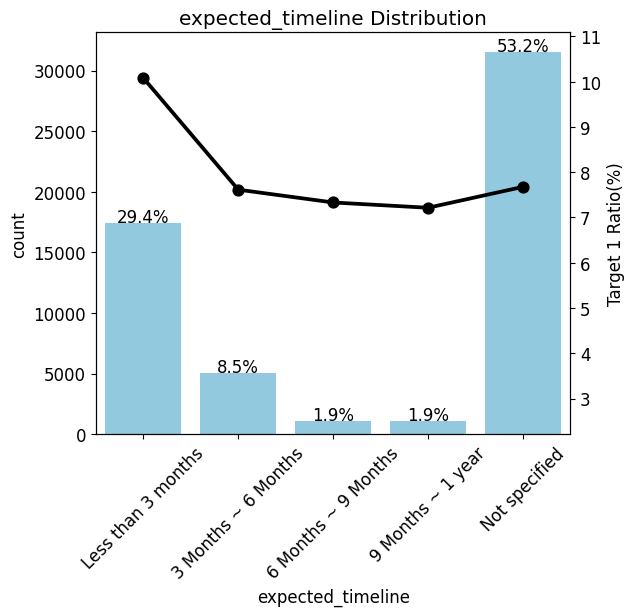

In [ ]:
from pandas.api.types import CategoricalDtype
ord_1 = ['expected_timeline']
ord_1_value = ['Less than 3 months', '3 Months ~ 6 Months', '6 Months ~ 9 Months', '9 Months ~ 1 year', 'Not specified']

# 순서를 지정한 범주형 데이터 타입
ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)

# 데이터 타입 변경
df_train['expected_timeline'] = df_train['expected_timeline'].astype(ord_1_dtype)
plot_cat_dist_with_true_ratio(df_train, ord_1,
                              num_rows=2, num_cols=2, size=(15, 12))

-

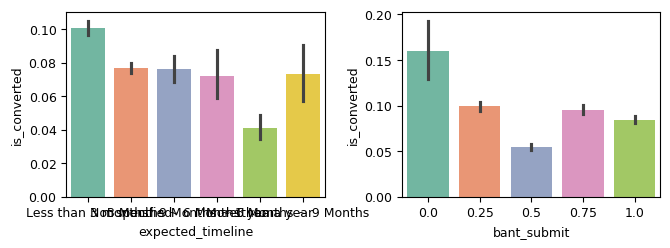

In [ ]:
plot_target_ratio_by_features(df_train, ord_features,'is_converted',6, 3)

## 3. 명목형 피쳐

In [ ]:
# 명목형
nom_features = ['customer_country',
                'customer_country.1',
                'business_unit',
                'customer_idx',
                'customer_type',
                'customer_job',
                'inquiry_type',
                'product_category',
                'product_subcategory',
                'product_modelname',
                'customer_position',
                'response_corporate',
                'business_area',
                'business_subarea',
                'lead_owner' ,
								'customer_region', #파생변수
								'customer_position.1' # 파생변수
								]
nom_feature_data = df_train[nom_features]
resumetable(nom_feature_data)


데이터 세트 형상: (59299, 17)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,customer_country,object,3482,170,Philippines,Philippines,India
1,customer_country.1,object,982,15399,/Quezon City/Philippines,/PH-00/Philippines,/Kolkata /India
2,business_unit,object,0,5,AS,AS,AS
3,customer_idx,int64,0,35112,32160,23122,1755
4,customer_type,object,43961,6,End Customer,End Customer,End Customer
5,customer_job,object,0,34,purchasing,media and communication,engineering
6,inquiry_type,object,0,9,Quotation or Purchase Consultation,Quotation or Purchase Consultation,Product Information
7,product_category,object,0,357,multi-split,multi-split,single-split
8,product_subcategory,object,50064,330,NaN,NaN,NaN
9,product_modelname,object,50070,665,NaN,NaN,NaN


### 명목형 피처 분포

In [ ]:
# 경고문구 삭제
import warnings
warnings.filterwarnings("ignore")

IndexError: index 12 is out of bounds for GridSpec with size 12

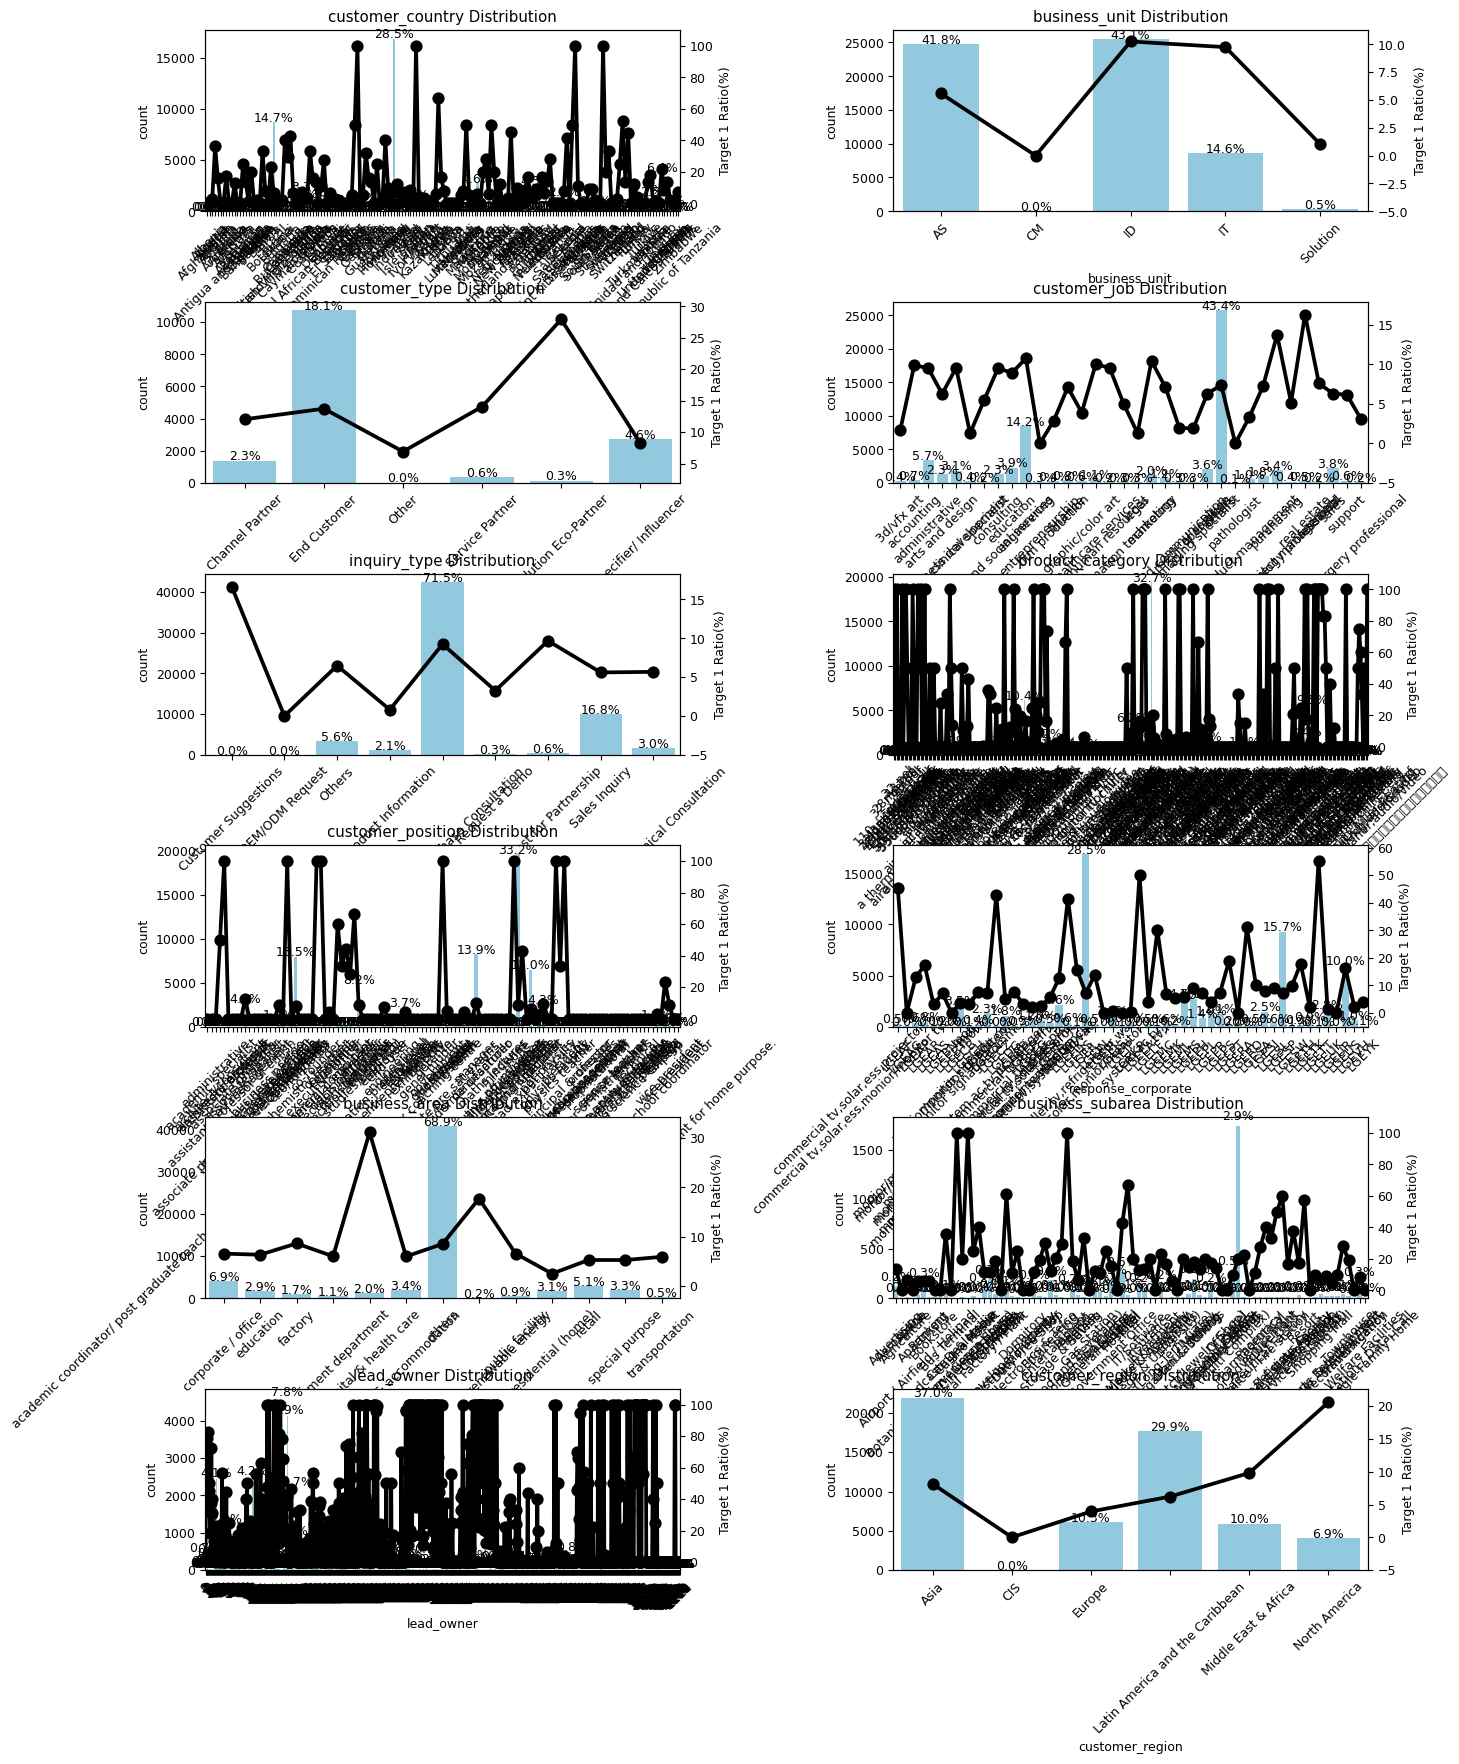

In [ ]:
#### 명목형 변수에 대한 피쳐값 1 비율 시각화 ####
nom_features = ['customer_country',
                # 'customer_country.1',
                'business_unit',
                # 'customer_idx',
                'customer_type',
                'customer_job',
                'inquiry_type',
                'product_category',
                # 'product_subcategory',
                # 'product_modelname',
                'customer_position',
                'response_corporate',
                'business_area',
                'business_subarea',
                'lead_owner' ,
								'customer_region', #파생변수
								'customer_position.1' # 파생변수
								] # 명목형 피처


plot_cat_dist_with_true_ratio(df_train, nom_features, num_rows=7, num_cols=2)

In [ ]:
# df_test에서 'inquiry_type'이 'Product Information'인 행만 필터링하여 출력
# 전체 5271개 값 중 68개 존재
print(df_test['inquiry_type'].value_counts().sum())

filtered_df = len(df_test[df_test['inquiry_type'] == 'Product Information'])
print(filtered_df)

total_values = 5271
existing_values = 68

ratio = (existing_values / total_values) * 100
print("존재하는 값의 비율: {:.2f}%".format(ratio))

5271
68
존재하는 값의 비율: 1.29%


In [ ]:
#### 고유값 수가 너무 많은 컬럼은 따로 보기 ####

def calculate_conversion_ratio(df, feature):
    # 피쳐의 각 고유값별로 True의 개수와 전체 True의 개수를 계산
    counts = df[df['is_converted']][feature].value_counts()
    total_counts = df['is_converted'].sum()

    # 각 고유값별 비율을 계산하고 백분율로 변환
    ratios = counts / total_counts * 100

    # 비율이 높은 순으로 내림차순 정렬
    ratios_sorted = ratios.sort_values(ascending=False)

    # 비율을 문자열로 변환하여 뒤에 % 기호를 추가
    ratios_with_percent = ratios_sorted.apply(lambda x: f"{x:.2f}%")

    return ratios_with_percent

features = ['product_subcategory',
            'product_modelname',
            'customer_country', #'customer_country.1'과 비교 위해 추가
            'customer_country.1',
            'customer_idx',
            'customer_type']

for feature in features:
    print(f"Conversion ratios for {feature}:")
    conversion_ratios = calculate_conversion_ratio(df_train, feature)
    print(conversion_ratios)
    print("\n")


Conversion ratios for product_subcategory:
Interactive Digital Board                        1.75%
TR3BF Series                                     1.03%
55" 500 nits FHD 0.44mm Even Bezel Video Wall    0.97%
49" 500 nits FHD Slim Bezel Video Wall           0.87%
Transparent OLED Signage                         0.85%
                                                 ...  
SuperSign Simple Editor                          0.02%
Pro:Centric                                      0.02%
Pro:Centric TV                                   0.02%
Pro:Centeric TV                                  0.02%
Split                                            0.02%
Name: product_subcategory, Length: 192, dtype: object


Conversion ratios for product_modelname:
55VSM5J              0.97%
55CT5WJ              0.87%
43HT3WJ              0.70%
75TC3D               0.62%
55VSH7J              0.60%
                     ...  
49UH5J-H             0.02%
43US660H0SD.AWZ      0.02%
75UR640S (EU/CIS)    0.02%
43UR640S    

- 명목형 피쳐 분포 및 피처별 타깃값 1의 비율

1. 시각화해본 피쳐들은 타깃값 1에 대한 비율이 모든 고유값에 어느 정도 할당되어 있기 때문에, 모델링에 필요없는 피쳐는 없다

=> 명목형 피쳐이므로 순서를 무시해도된다. 따라서 원핫 인코딩

1-2. 'inquiry_type'이 Product Information 값을 가지는 경우, 타겟값이 '71.5%'나 차지한다 (다른 값들은 최대가 43.1%)
=> 해당 값에 가중치를 주는 파생변수를 생성해보자

2. 아래 5개의 컬럼은, 컬럼의 고유값이 너무 많아(3만개, 300개 등) 따로 표시했다
  > `'product_subcategory',
    'product_modelname',
    'customer_country.1',
    'customer_idx',
    'customer_type',`

2-1. Conversion ratios for customer_idx가 25096일때 '49.92%'의 전환율을 보였으나, test데이터에는 존재하지 않는 데이터이므로 무시한다.
다른 데이터들도 30.33%가 최대

=> 따라서 모두 원핫 인코딩

## 4. 그 외 수치형 피쳐

In [ ]:
#수치형
num_features = [ 'ver_win_rate_x',
                'ver_win_ratio_per_bu',
                'com_reg_ver_win_rate',
                'historical_existing_cnt',
                'lead_desc_length' ]
num_feature_data = df_train[num_features]
resumetable(num_feature_data)

데이터 세트 형상: (59299, 5)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값,세 번째 값
0,ver_win_rate_x,float64,0,13,0.003079,0.003079,0.003079
1,ver_win_ratio_per_bu,float64,0,24,0.026846,0.026846,0.026846
2,com_reg_ver_win_rate,float64,0,81,0.066667,0.066667,0.088889
3,historical_existing_cnt,float64,0,136,4.000000,12.000000,144.000000
4,lead_desc_length,int64,0,909,62.000000,96.000000,56.000000


### 연속형 피쳐 분포

- num_features =
                [ 'ver_win_rate_x',
                'ver_win_ratio_per_bu',
                'com_reg_ver_win_rate',
                'historical_existing_cnt',
                'lead_desc_length' ]

- 연속형 피처는 고윳값이 굉장히 많음, 구간을 나눠서 타깃값 1 비율 알아볼 것

✅ 결론

1. 고윳값별 비율이 다르므로, 타깃값 예측력이 있어,모든 피쳐를 살려야함.

2. ver_win_ratio_per_bu 컬럼의 경우, 순서형 변수와 같은 분포를 나타내므로 파생변수 생성 고려

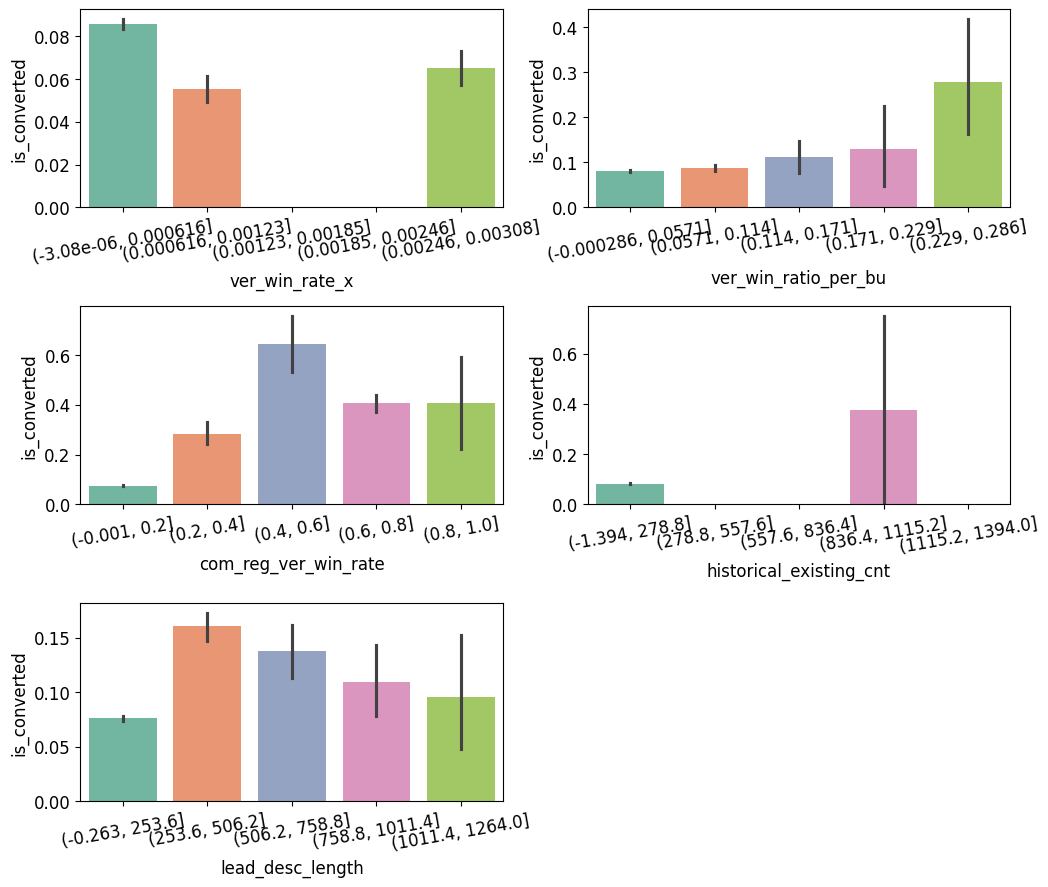

In [ ]:
#### 연속형 변수별 타깃값 1의 비율
cont_features = ['ver_win_rate_x',
          'ver_win_ratio_per_bu',
          'com_reg_ver_win_rate',
          'historical_existing_cnt',
          'lead_desc_length'
                 ]# 연속형 피처

plt.figure(figsize=(12, 18))          # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)        # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.5) # 서브플롯 간 여백 설정

for idx, cont_feature in enumerate(cont_features):
    # 값을 5개 구간으로 나누기
    # df_train[cont_feature] = pd.cut(df_train[cont_feature], 5) # 한번 함수 실행 후에는 주석처리

    ax = plt.subplot(grid[idx])       # 분포도를 그릴 서브플롯 설정
    sns.barplot(x=cont_feature, y='is_converted', data=df_train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) # x축 라벨 회전

# 모델 생성

## 1. 피처 엔지니어링
- 명목형 피처 원핫 인코딩
- 필요없는 피쳐 제거

- 데이터 합치기

In [ ]:
df_all = pd.concat([df_train, df_test])
df_all = df_all.drop('is_converted', axis = 1) # 타깃값 제거

In [ ]:
all_features = df_all.columns
all_features

Index(['Unnamed: 0', 'bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'customer_region',
       'customer_position.1', 'id'],
      dtype='object')

In [ ]:
# 수치형

num_features = [ 'ver_win_rate_x',
                'ver_win_ratio_per_bu',
                'com_reg_ver_win_rate',
                'historical_existing_cnt',
                'lead_desc_length' ]


#이진형

bin_features = ['id_strategic_ver',
                 'it_strategic_ver',
                 'idit_strategic_ver',
                  'ver_pro', 'ver_cus',
                  'enterprise' ]

#순서형
ord_features = ['expected_timeline',
                'bant_submit'  ]
#명목형

nom_features = ['customer_country',
                'customer_country.1',
                'business_unit',
                'customer_idx',
                'customer_type',
                'customer_job',
                'inquiry_type',
                'product_category',
                'product_subcategory',
                'product_modelname',
                'customer_position',
                'response_corporate',
                'business_area',
                'business_subarea',
                'lead_owner' ,
								'customer_region', #파생변수
								'customer_position.1' # 파생변수
								]